# Предсказание оттока пользователей

Данные: [train.csv](https://drive.google.com/file/d/1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K/view?usp=share_link),
[test.csv](https://drive.google.com/file/d/1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r/view?usp=share_link), [submission.csv](https://drive.google.com/file/d/199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y/view?usp=share_link).

# Метрика

Я использую стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации. К тому же она работает даже если классы в данных сильно несбалансированны.


# Первая часть. Исследование

In [77]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [78]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 90.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 27.9MB/s]


In [79]:
data = pd.read_csv('./train.csv')

In [80]:
test_data = pd.read_csv('./test.csv')

In [81]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [83]:
test_data.isna().sum()

,0
ClientPeriod,0
MonthlySpending,0
TotalSpent,0
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


In [84]:
data.isna().sum()

,0
ClientPeriod,0
MonthlySpending,0
TotalSpent,0
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


NaN значений в тренировочном и тестовом датасетах не обнаружено

Выведу несколько случайных строк датасета, чтобы посмотреть на данные

In [85]:
data.iloc[[1, 10, 20]]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
10,16,78.75,1218.25,Male,1,No,No,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,0
20,61,84.90,5264.5,Male,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,One year,No,Bank transfer (automatic),0


## Анализ данных

In [86]:
data[data['TotalSpent'] == ' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


**Замечаем, что в столбце TotalSpent есть пропущенные значения. Так как соответствующие значения ClientPeriod равны 0, то это говорит о том, что данные клиенты являются новыми, поэтому заполним 0 пустые значения в столбце TotalSpent**

In [87]:
# Замена пустых строк на 0
data.replace(" ", '0', inplace=True)
test_data.replace(" ", '0', inplace=True)

столбец TotalSpent имел тип object, приводим его к типу float для дальнейшей работы с этим признаком

In [88]:
data['TotalSpent'] = data['TotalSpent'].astype(float) # столбец TotalSpent имел тип object, приводим его к типу float для дальнейшей работы с этим признаком
test_data['TotalSpent'] = test_data['TotalSpent'].astype(float)

Проверим, дублируются ли некоторые из образцов.

In [89]:
data[data.duplicated(keep = False)]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
7,1,45.70,45.70,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
170,1,69.90,69.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
329,1,69.35,69.35,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
409,1,69.60,69.60,Female,1,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
594,1,20.05,20.05,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
838,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1068,1,70.15,70.15,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
1217,1,20.20,20.20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,1
1236,1,45.30,45.30,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,1
1384,1,69.90,69.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1


In [90]:
data[data.drop(columns = 'Churn').duplicated(keep = False)]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
7,1,45.70,45.70,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
170,1,69.90,69.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
329,1,69.35,69.35,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
409,1,69.60,69.60,Female,1,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
594,1,20.05,20.05,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
838,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
881,1,20.40,20.40,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1040,1,45.40,45.40,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0
1068,1,70.15,70.15,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
1217,1,20.20,20.20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,1


In [91]:
data.duplicated(keep = False).sum()

28

In [92]:
data.drop(columns = 'Churn').duplicated(keep = False).sum()

41

Видим, что некоторые образцы дублируются, то есть некоторые клиенты записаны по несколько раз в наш data frame. Более того, у некоторых дублирующихся образцов отличается значение целевой переменной. Во избежание противоречий удалим такие образцы.

In [93]:
data = data[~data.drop(columns = 'Churn', axis=1).duplicated(keep=False)]

Построим гистограммы для числовых признаков

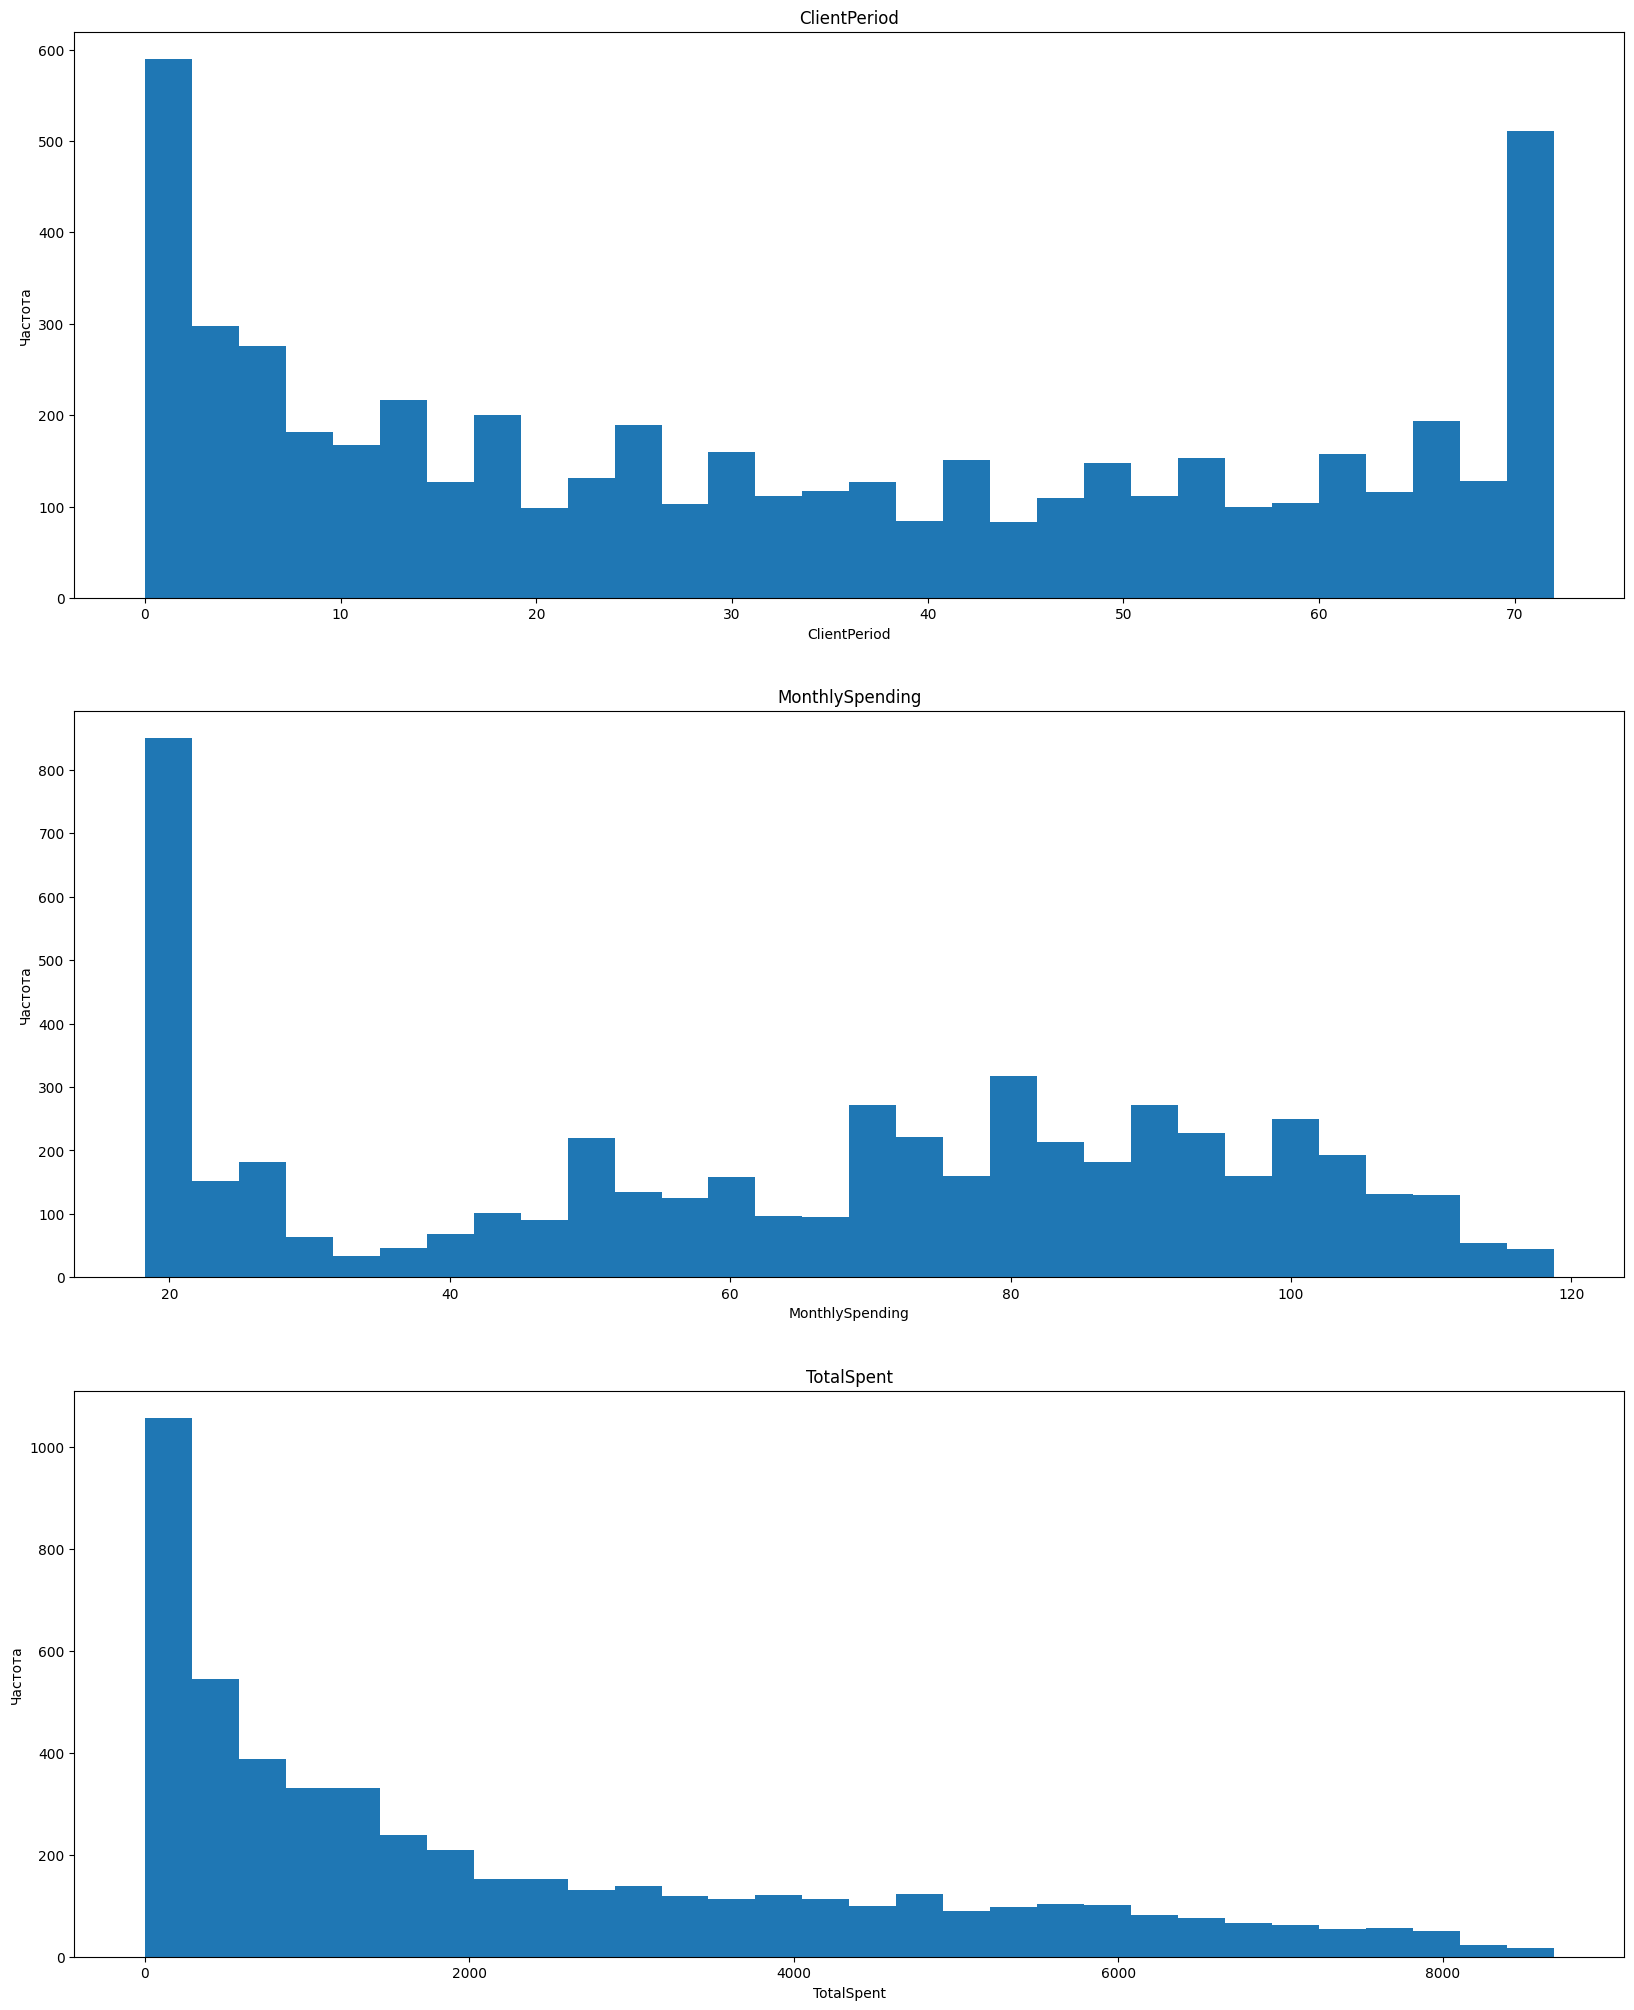

In [94]:
fig, axes = plt.subplots(3, 1, figsize=(20, 25))
for ax, col in zip(axes.flatten(), num_cols):
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Частота')
    ax.hist(data[col], bins = 30)

Построим boxplot'ы для числовых признаков

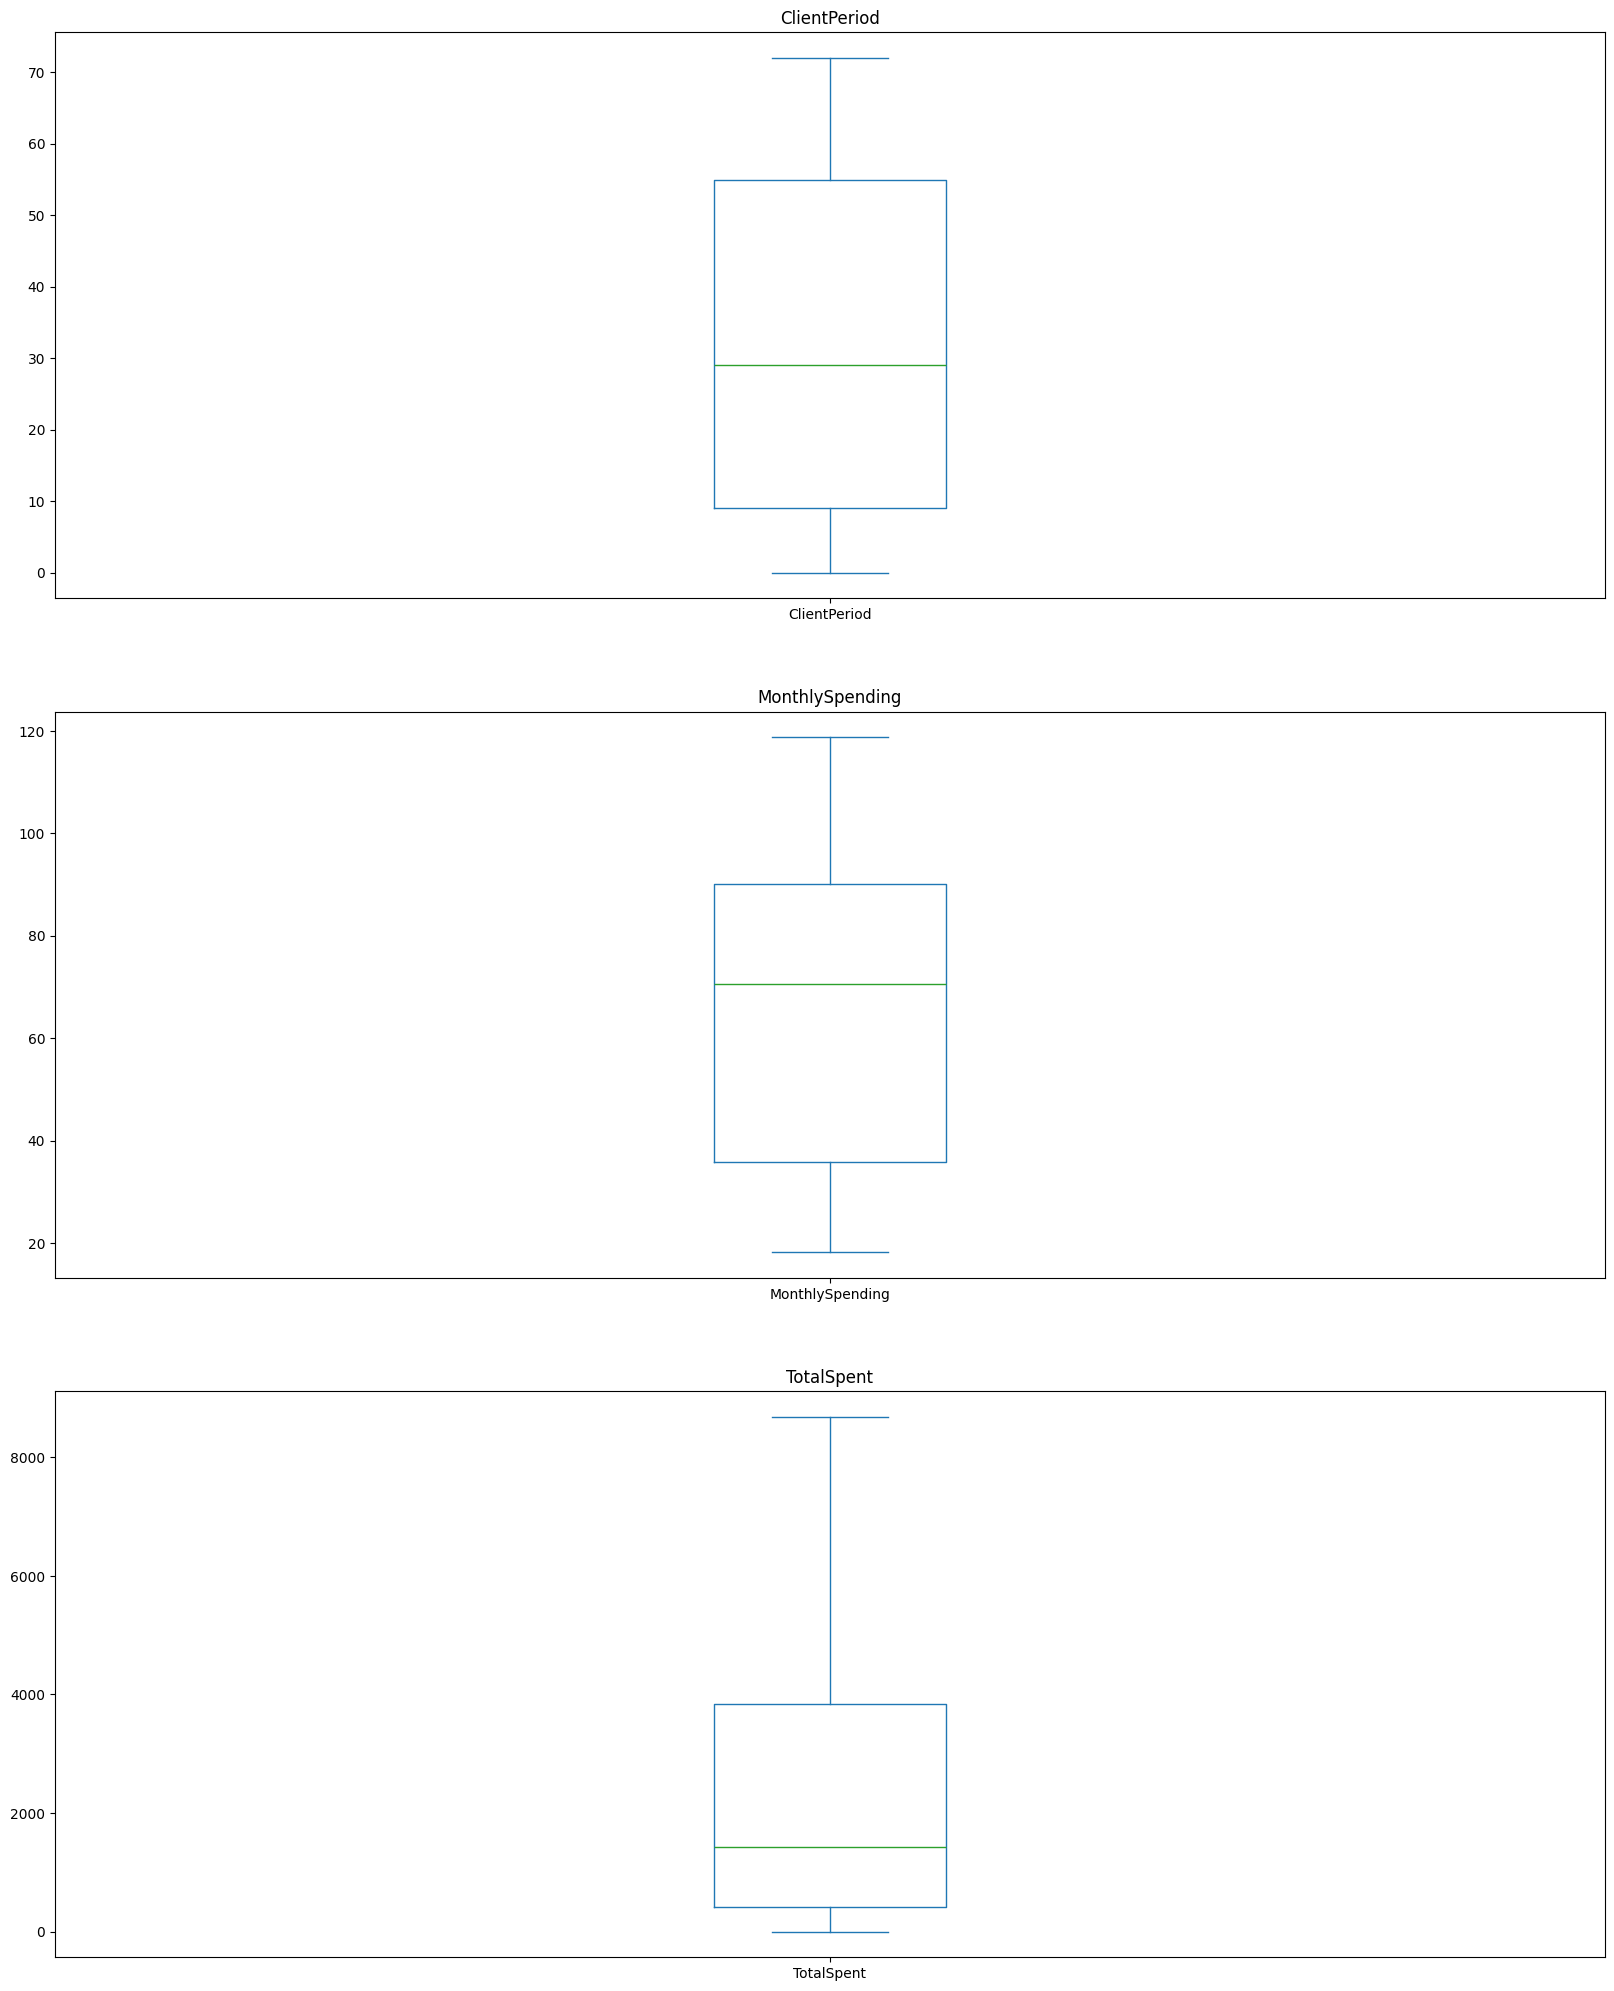

In [95]:
fig, axes = plt.subplots(3, 1, figsize=(20, 25))
for ax, col in zip(axes.flatten(), num_cols):
    ax.set_title(col)
    data[col].plot(kind="box", ax=ax)

Выведем количество каждого значения для каждого признака с помощью метода value_counts()

In [96]:
for cat_col in cat_cols:
  print(data[cat_col].value_counts())

Sex
Male      2634
Female    2607
Name: count, dtype: int64
IsSeniorCitizen
0    4401
1     840
Name: count, dtype: int64
HasPartner
No     2664
Yes    2577
Name: count, dtype: int64
HasChild
No     3635
Yes    1606
Name: count, dtype: int64
HasPhoneService
Yes    4720
No      521
Name: count, dtype: int64
HasMultiplePhoneNumbers
No                  2470
Yes                 2250
No phone service     521
Name: count, dtype: int64
HasInternetService
Fiber optic    2329
DSL            1794
No             1118
Name: count, dtype: int64
HasOnlineSecurityService
No                     2594
Yes                    1529
No internet service    1118
Name: count, dtype: int64
HasOnlineBackup
No                     2314
Yes                    1809
No internet service    1118
Name: count, dtype: int64
HasDeviceProtection
No                     2299
Yes                    1824
No internet service    1118
Name: count, dtype: int64
HasTechSupportAccess
No                     2586
Yes                   

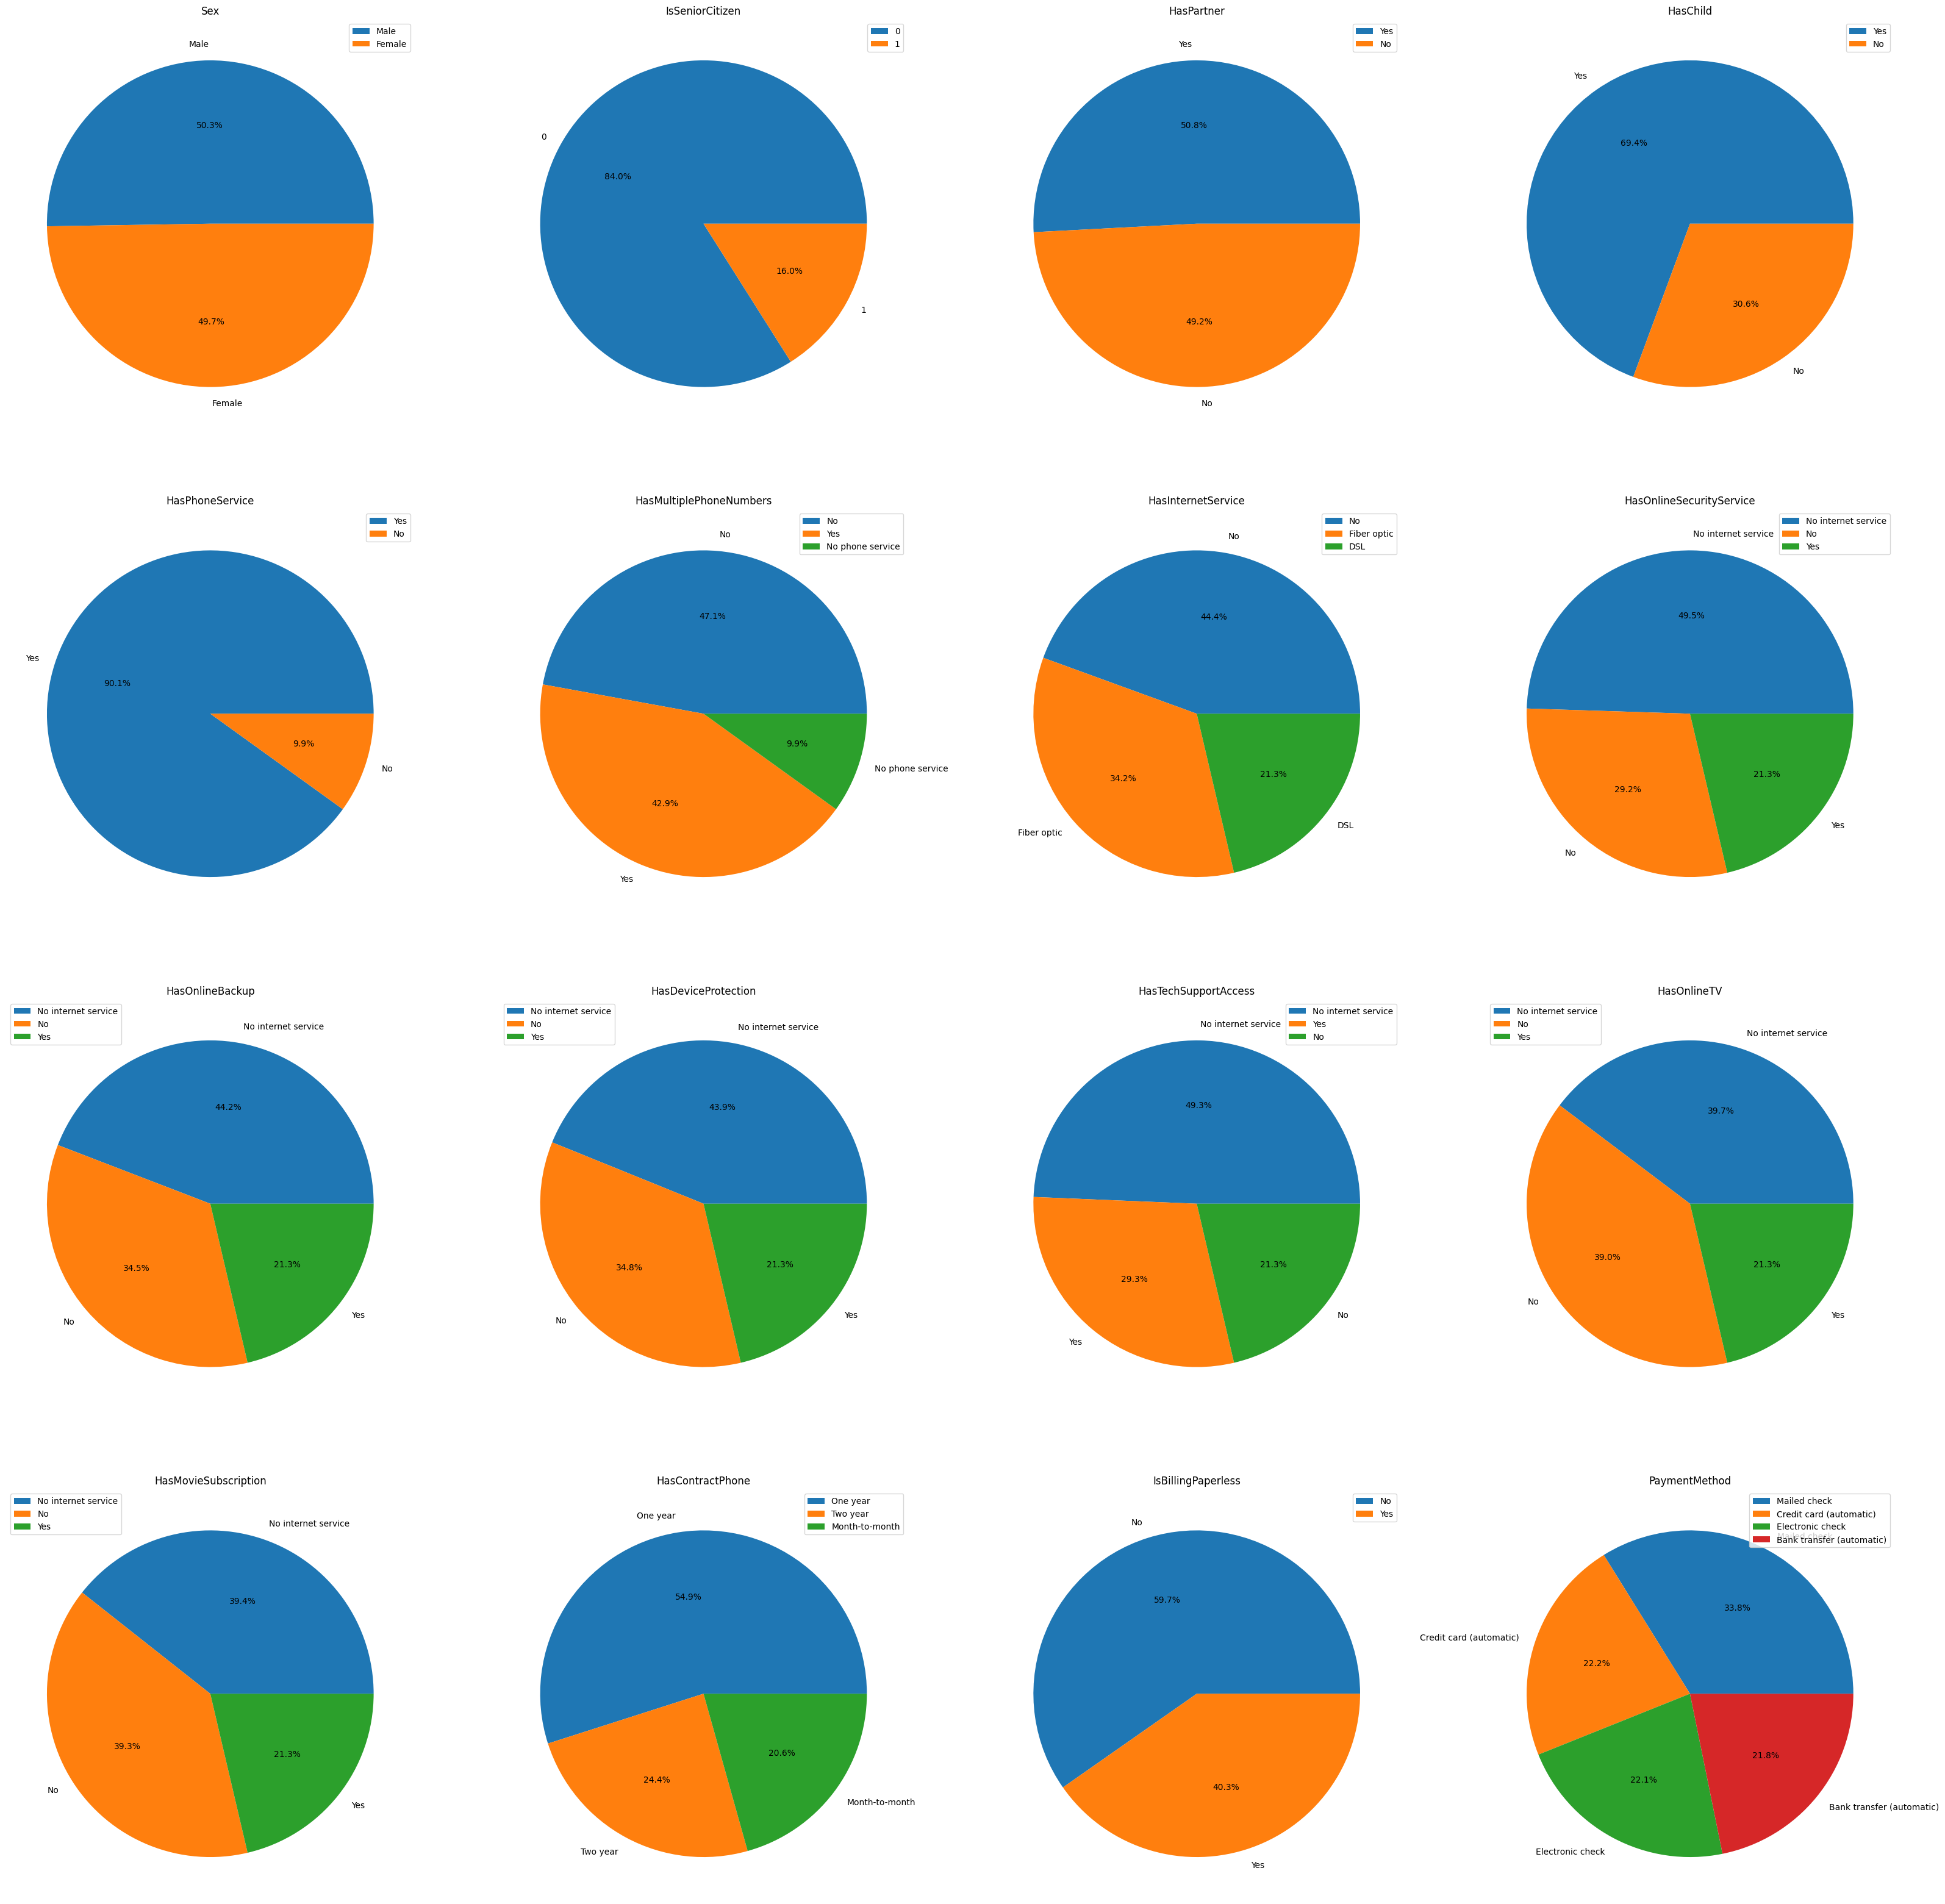

In [97]:
fig, axes = plt.subplots(4, 4, figsize=(40, 40))
for ax, col in zip(axes.flatten(), cat_cols):
    ax.set_title(col)
    ax.pie(data[col].value_counts(), autopct='%.1f%%', labels = data[col].unique())
    ax.legend()

Тип целевой переменной: int64


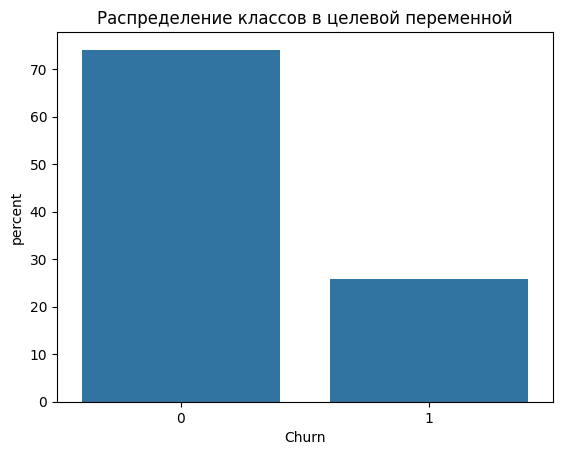

In [98]:
import seaborn as sns
target_type = data['Churn'].dtype
print(f"Тип целевой переменной: {target_type}")
# Визуализация распределения классов
sns.countplot(x='Churn', data=data, stat = 'percent')
plt.title('Распределение классов в целевой переменной')
plt.show()

Целевая переменная является категориальной. Данные несбалансированы, Churn = 0 встречается более чем в 2 раза чаще чем Churn = 1. Поскольку присутствует дисбаланс классов, вместо метрики accuracy будем использовать ROC-AUC.

1) Для числовых признаков построены гистограмма или boxplot.

2) Для категориальных признаков посчитано количество каждого значения для каждого признака. Для каждого признака построена круговая диаграмма.

3) Сделан вывод о дисбалансе классов.


## Применение линейных моделей

Обработаем данные для того, чтобы к ним можно было применить LogisticRegression. То есть отнормируем числовые признаки, а категориальные закодируем с помощью one-hot-encoding'а.

In [99]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [100]:
X = data.drop('Churn', axis = 1)
y = data['Churn']

In [101]:
X_scaled = X.copy()
test_data_scaled = test_data.copy()
scaler = StandardScaler()
model = scaler.fit(X[num_cols])
X_scaled[num_cols] = model.transform(X[num_cols])
test_data_scaled[num_cols] = model.transform(test_data[num_cols])

In [102]:
train_data_onehot = X_scaled.copy()
test_data_onehot = test_data_scaled.copy()

In [103]:
onehotencoder = OneHotEncoder(drop = 'first', sparse_output = False)
model = onehotencoder.fit(X_scaled[cat_cols])
encoded_train_df = pd.DataFrame(model.transform(X_scaled[cat_cols]), columns = onehotencoder.get_feature_names_out())
encoded_test_df = pd.DataFrame(model.transform(test_data_scaled[cat_cols]), columns = onehotencoder.get_feature_names_out())

In [104]:
train_data_onehot = train_data_onehot.drop(cat_cols, axis = 1)
test_data_onehot = test_data_onehot.drop(cat_cols, axis = 1)
train_data_onehot = train_data_onehot.reset_index(drop = True)
test_data_onehot = test_data_onehot.reset_index(drop = True)
encoded_train_df = encoded_train_df.reset_index(drop = True)
encoded_test_df = encoded_test_df.reset_index(drop = True)
train_data_onehot = pd.concat([train_data_onehot, encoded_train_df], axis=1)
test_data_onehot = pd.concat([test_data_onehot, encoded_test_df], axis=1)
y = y.reset_index(drop = True)
dataframe = pd.concat([train_data_onehot, y], axis = 1)

Найдём матрицу корреляций, для меньшего загромождения при её выводе оставим коэффициенты, по модулю не меньшие чем 0.5

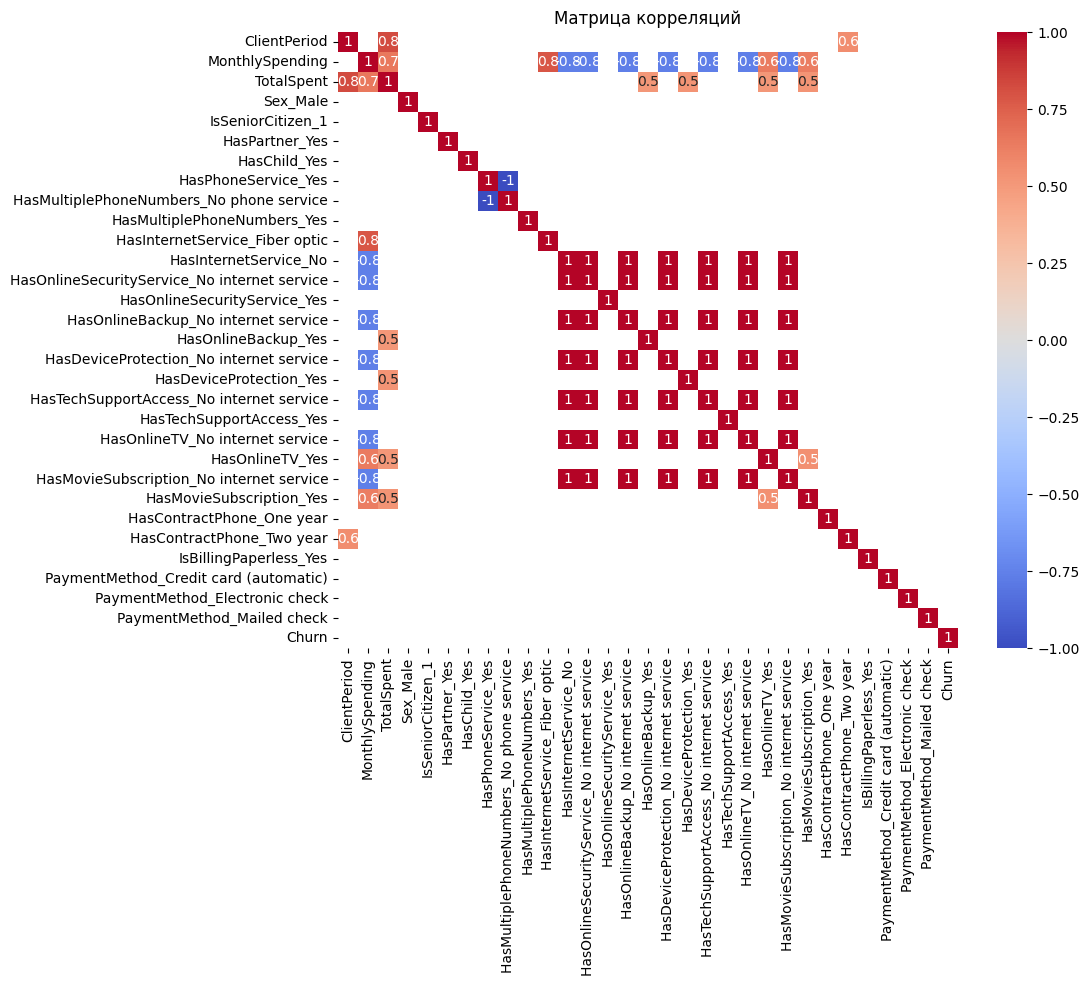

In [105]:
# Рассчитываем матрицу корреляций
correlation_matrix = dataframe.corr()

# Создаем тепловую карту (heatmap)
plt.figure(figsize=(10, 8))  # Размер графика
sns.heatmap(correlation_matrix, annot=True, fmt='.1g', cmap='coolwarm', mask=correlation_matrix.abs() < 0.5)  # Показываем только значимые корреляции
plt.title('Матрица корреляций')
plt.show()


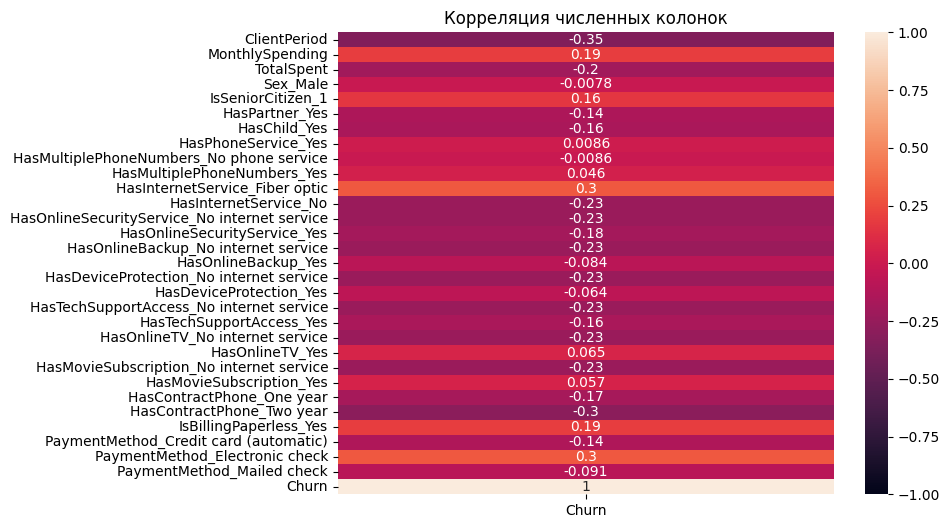

In [134]:
numeric_columns = dataframe.select_dtypes(include=['number', 'bool']).columns.tolist()
categorical_columns = dataframe.select_dtypes(exclude=['number', 'bool']).columns.tolist()

correlation_matrix = dataframe[numeric_columns].corr()

corr_target = correlation_matrix[['Churn']]

plt.figure(figsize=(8,6))
sns.heatmap(corr_target, annot=True, vmin=-1, vmax=1)
plt.title('Корреляция численных колонок')
plt.show()

Из heatmap видно, что есть признаки с высокой по модулю корреляцией. В качестве порогового значения корреляции выберем 0.7. В случаях, когда два признака имеют коэффициент корреляции по модулю больший чем 0.7 один из таких признаков удаляем, чтобы убрать высокую линейную зависимость между признаками. Сначала разберёмся с такими парамами признаков, где коэффициент равен 1 или -1. В таких парах оставим только 1 из признаков, второй удалим. Это реализовано в ячейке ниже.

In [106]:
train_data = dataframe.drop(columns = ['HasOnlineSecurityService_No internet service', 'HasOnlineBackup_No internet service', 'HasDeviceProtection_No internet service', 'HasTechSupportAccess_No internet service', 'HasOnlineTV_No internet service', 'HasMovieSubscription_No internet service', 'HasMultiplePhoneNumbers_No phone service'], axis = 1)

In [107]:
test_data = test_data_onehot.drop(columns = ['HasOnlineSecurityService_No internet service', 'HasOnlineBackup_No internet service', 'HasDeviceProtection_No internet service', 'HasTechSupportAccess_No internet service', 'HasOnlineTV_No internet service', 'HasMovieSubscription_No internet service', 'HasMultiplePhoneNumbers_No phone service'], axis = 1)

Признаки 'TotalSpent' и 'ClientPeriod' имеют коэффициент корреляции равный 0.8 --> удалим 'Client Period'

'HasInternetService_Fiber optic' и 'MonthlySpending' имеют коэфф. корреляции 0.8, 'HasInternetSerive_No' и 'MonthlySpending' имеют коэффициент корреляции -0.8, 'TotalSpent' и 'MonthlySpending' имеют коэффициент корреляции 0.7 --> удалим признак 'Monthly Spending'.

In [108]:
train_data = train_data.drop(columns = ['ClientPeriod', 'MonthlySpending'], axis = 1)
test_data = test_data.drop(columns = ['ClientPeriod', 'MonthlySpending'], axis = 1)

In [109]:
X = train_data.drop(columns = ['Churn'])
y = train_data['Churn']

In [110]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [111]:
from sklearn.metrics import roc_auc_score

In [112]:
log_reg_cv = LogisticRegressionCV(cv = 5, scoring = 'roc_auc', refit = True)
clf = log_reg_cv.fit(X_train, y_train)
y_train_pred = clf.predict_proba(X_train)[:, 1]
y_valid_pred = clf.predict_proba(X_valid)[:, 1]
print("Оптимальное значение параметра C: ", clf.C_[0])


Оптимальное значение параметра C:  2.782559402207126


In [113]:
print("roc_auc_score on train: ", roc_auc_score(y_train, y_train_pred))
print("roc_auc_score on valid: ", roc_auc_score(y_valid, y_valid_pred))

roc_auc_score on train:  0.842998006613076
roc_auc_score on valid:  0.8384388440280851


In [114]:
best_score = log_reg_cv.score(X_valid, y_valid)
print("Лучший ROC AUC score:", best_score)

Лучший ROC AUC score: 0.8384388440280851


**Лучший показатель качества по метрике roc_auc на валидационной выборке равен 0.8384, этот показатель достигнут при значении параметра С = 2.7826**

## Применение градиентного бустинга


Буду использовать catboost, категориальные признаки при этом не кодирую, так как Catboost сделает это сам (передавая в .fit() cat_features=cat_cols). Численные признаки не нормирую, так как это не нужно делать для моделей, основанных на деревьях решений.

In [115]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [125]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [117]:
data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

Всего реализуем два варианта предварительной обработки:

1. Никакие признаки не удаляем
2. Удаляем признаки, имеющие высокую корреляцию с другими признаками. Ранее из матрицы корреляций были выявлены следующие признаки, которые можно удалить: ClientPeriod, MonthlySpending


*Первый вариант предварительной обработки*

In [154]:
X = data.drop(columns = ['Churn'])
y = data['Churn']

In [155]:
X['IsSeniorCitizen'] = X['IsSeniorCitizen'].astype(object)
test_data['IsSeniorCitizen'] = test_data['IsSeniorCitizen'].astype(object)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [159]:
categorical_indices_list = X.select_dtypes(include=['object']).columns.tolist()
categorical_indices = [X.columns.get_loc(col) for col in categorical_indices_list] # извлекаем индексы категориальных столбцов

1. Обучим CatBoost со стандартными параметрами

In [178]:
model = CatBoostClassifier(cat_features = categorical_indices, verbose = 0)
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

In [132]:
print("train roc_auc score: ", roc_auc_score(y_true = y_train, y_score = y_train_pred))
print("test roc_auc score: ", roc_auc_score(y_true = y_test, y_score = y_test_pred))

train roc_auc score:  0.8980361281001294
test roc_auc score:  0.823387759625419


2. Выполним поиск оптимальных гиперпараметров для CatBoost (n_estimators и learning rate) c помощью GridSearchCV по метрике roc-auc

In [129]:
boosting_model = CatBoostClassifier(cat_features = categorical_indices, verbose = 0)
param_grid = {'n_estimators': np.arange(100, 400, 50), 'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]}
grid_search = GridSearchCV(estimator=boosting_model, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)
best_model = grid_search.best_estimator_
y_train_predicted = best_model.predict_proba(X_train)[:, 1]
y_test_predicted = best_model.predict_proba(X_test)[:, 1]

Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 100}


In [130]:
print("train roc_auc score: ", roc_auc_score(y_true = y_train, y_score = y_train_predicted))
print("test roc_auc score: ", roc_auc_score(y_true = y_test, y_score = y_test_predicted))

train roc_auc score:  0.8684741249310792
test roc_auc score:  0.8278391407541489


Для модели Cat Boost получено качество roc_auc =  0.8278 при n_estimators = 100, lr = 0.1

*Второй вариант предварительной обработки*

In [195]:
data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [196]:
X = data.drop(columns = ['Churn', 'ClientPeriod', 'MonthlySpending'])
y = data['Churn']

In [197]:
X['IsSeniorCitizen'] = X['IsSeniorCitizen'].astype(object)
test_data['IsSeniorCitizen'] = test_data['IsSeniorCitizen'].astype(object)

In [198]:
test_data = test_data.drop(columns = ['ClientPeriod', 'MonthlySpending'])

In [199]:
categorical_indices_list = X.select_dtypes(include=['object']).columns.tolist()
categorical_idxs = [X.columns.get_loc(col) for col in categorical_indices_list]

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

1. Обучим CatBoost со стандартными параметрами

In [201]:
catboost = CatBoostClassifier(cat_features = categorical_idxs, verbose = 0)
catboost.fit(X_train, y_train)
y_train_predictions = catboost.predict_proba(X_train)[:, 1]
y_test_predictions = catboost.predict_proba(X_test)[:, 1]

In [202]:
print("train roc_auc score: ", roc_auc_score(y_true = y_train, y_score = y_train_predictions))
print("test roc_auc score: ", roc_auc_score(y_true = y_test, y_score = y_test_predictions))

train roc_auc score:  0.9120581317214043
test roc_auc score:  0.818308382818777


2. Выполним поиск оптимальных гиперпараметров для CatBoost (n_estimators и learning rate) c помощью GridSearchCV по метрике roc-auc

In [204]:
catboost_model = CatBoostClassifier(cat_features = categorical_indices, verbose = 0)
param_grid = {'n_estimators': np.arange(100, 400, 50), 'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]}
grid_search_cv = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search_cv.fit(X_train, y_train)
best_parameters = grid_search_cv.best_params_
print("Лучшие параметры:", best_params)
best_catboost_model = grid_search_cv.best_estimator_

Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 100}


In [205]:
y_train_pr = best_catboost_model.predict_proba(X_train)[:, 1]
y_test_pr = best_catboost_model.predict_proba(X_test)[:, 1]

In [206]:
print("train roc_auc score: ", roc_auc_score(y_true = y_train, y_score = y_train_pr))
print("test roc_auc score: ", roc_auc_score(y_true = y_test, y_score = y_test_pr))

train roc_auc score:  0.8666839246362057
test roc_auc score:  0.8172648017657761


# Предсказания

Лучший показатель качества по метрике roc_auc на валидационной выборке равен 0.8384, его даёт модель LogisticRegressionCV на предобработанных данных

In [ ]:
best_model = log_reg_cv

In [ ]:
X_test = test_data
submission = pd.read_csv('./submission.csv')
submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv', index = False)